In [1]:
import os
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,40))
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tifi
import PIL
import cv2
from tqdm import tqdm, trange

import tensorflow as tf 
from tensorflow import keras 
from keras.utils import to_categorical
from keras import layers

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
df_original = pd.read_csv('/home/bear/prakash/aai541/finalproject/data/train.csv')
df_test = pd.read_csv('/home/bear/prakash/aai541/finalproject/data/test.csv')
df_other = pd.read_csv('/home/bear/prakash/aai541/finalproject/data/other.csv')
df_original.shape
print("Train size:", len(df_original), "Train Patient Samples:", len(df_original.patient_id.unique()))
print("Test size:", len(df_test), "Test Patient Samples:", len(df_test.patient_id.unique()))
print("Other size:", len(df_other), "Other Patient Samples:", len(df_other.patient_id.unique()))

Train size: 754 Train Patient Samples: 632
Test size: 4 Test Patient Samples: 4
Other size: 396 Other Patient Samples: 336


In [4]:
print(df_original.head(5))

   image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA
3  01adc5_0         11     01adc5          0   LAA
4  026c97_0          4     026c97          0    CE


In [5]:
#Fixing classimbalance
dfCI = df_original
index = len(dfCI)

for x in range(int(df_original.shape[0])):

    label = df_original.label[x]
    if(label == "LAA"):
        dfCI.loc[index] = [df_original.image_id[x], df_original.center_id[x], df_original.patient_id[x], 
                                     df_original.image_num[x], df_original.label[x]]
        index = index+1
        dfCI.loc[index] = [df_original.image_id[x], df_original.center_id[x], df_original.patient_id[x], 
                                     df_original.image_num[x], df_original.label[x]]
        index = index+1
print('After Class Imbalance Shape:', len(dfCI), index)

After Class Imbalance Shape: 1168 1168


In [6]:
def ExploratoryDataAnalysis(df):
    
    print('\033[1m' +'EXPLORATORY DATA ANALYSIS :'+ '\033[0m\n')
    print('\033[1m' + 'Shape of the data (rows, columns):' + '\033[0m')
    print(df.shape, 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'All columns from the dataframe :' + '\033[0m')
    print(df.columns, 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'Datatypes and Missing values:' + '\033[0m')
    print(df.info(), 
          '\n------------------------------------------------------------------------------------\n')
    
    for col in df.columns:
        print('\033[1m' + 'Unique values in {} :'.format(col) + '\033[0m',len(df[col].unique()))
    print('\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'Summary statistics for the data :' + '\033[0m')
    print(df.describe(include='all'), 
          '\n------------------------------------------------------------------------------------\n')
    
        
    print('\033[1m' + 'Memory used by the data :' + '\033[0m')
    print(df.memory_usage(), 
          '\n------------------------------------------------------------------------------------\n')
    
    print('\033[1m' + 'Number of duplicate values :' + '\033[0m')
    print(df.duplicated().sum())
          
ExploratoryDataAnalysis(df_original)
ExploratoryDataAnalysis(df_test)
ExploratoryDataAnalysis(df_other)

EXPLORATORY DATA ANALYSIS :

Shape of the data (rows, columns):
(1168, 5) 
------------------------------------------------------------------------------------

All columns from the dataframe :
Index(['image_id', 'center_id', 'patient_id', 'image_num', 'label'], dtype='object') 
------------------------------------------------------------------------------------

Datatypes and Missing values:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 0 to 1167
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    1168 non-null   object
 1   center_id   1168 non-null   int64 
 2   patient_id  1168 non-null   object
 3   image_num   1168 non-null   int64 
 4   label       1168 non-null   object
dtypes: int64(2), object(3)
memory usage: 54.8+ KB
None 
------------------------------------------------------------------------------------

Unique values in image_id : 754
Unique values in center_id : 11
Unique valu

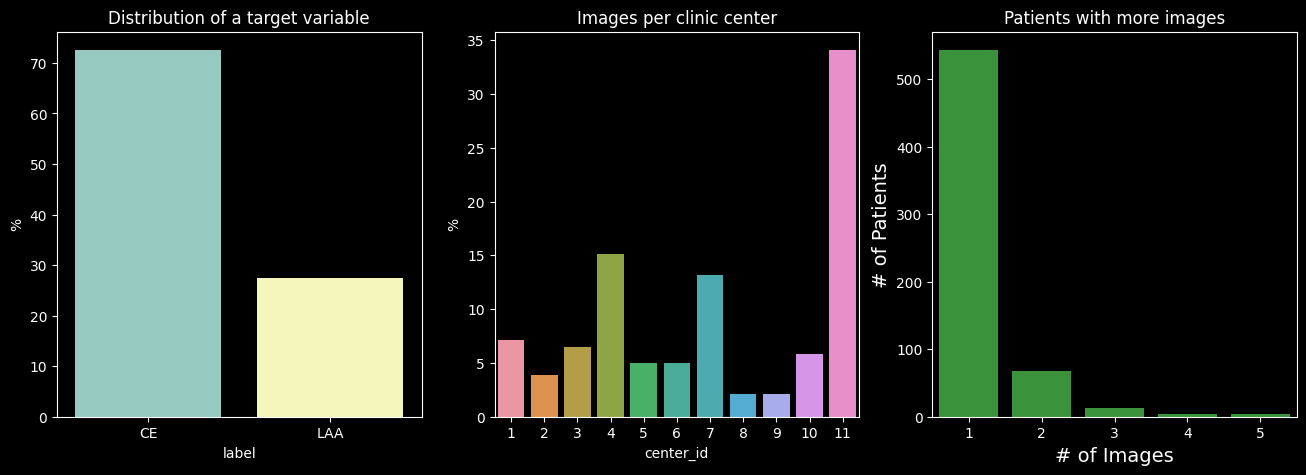

In [38]:
plt.style.use('dark_background')
labels = df_original.groupby('label')['label'].count().div(len(df_original)).mul(100)
centers = df_original.groupby("center_id")['center_id'].count().div(len(df_original)).mul(100)
fig, ax = plt.subplots(1,3, figsize=(16,5))

sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")
sns.barplot(x=centers.index, y=centers.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")

sns.countplot(x=df_original["patient_id"].value_counts().values,
             color="tab:green", ax=ax[2])
ax[2].set_title("Patients with more images")
ax[2].set_xlabel("# of Images", fontsize=14)
ax[2].set_ylabel("# of Patients", fontsize=14)
plt.show()

<AxesSubplot: ylabel='label'>

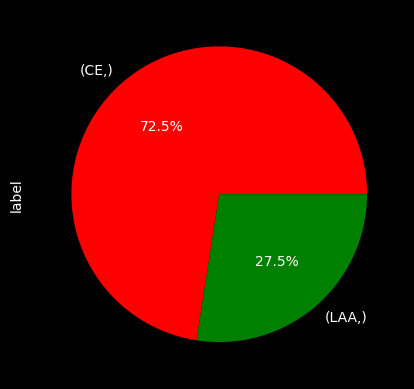

In [31]:
df_original[["label"]].value_counts().plot.pie(autopct='%1.1f%%',ylabel="label", colors = ['red', 'green'])

In [53]:
# images does each patient usually have?
# A: 1
import plotly.express as px
discrete_color_scheme = px.colors.qualitative.Dark24
plots_opacity = 0.9
df_patient_to_num_of_images = df_original[['patient_id', 'image_num']].groupby(by=['patient_id'], as_index=False).count().rename(columns={'image_num' : 'Number of images taken for the same patient'})
print(df_patient_to_num_of_images.groupby(by='Number of images taken for the same patient', as_index=False).count().to_string(index=False))
fig = px.scatter(df_patient_to_num_of_images, x="patient_id", y="Number of images taken for the same patient", 
                 marginal_y="violin", # possible marginal distribution types: histogram violin box rug
                 title='Number of images of the same patient',
                 color_discrete_sequence=discrete_color_scheme,
                 opacity=plots_opacity) 
fig.show()

 Number of images taken for the same patient  patient_id
                                           1         543
                                           2          68
                                           3          13
                                           4           4
                                           5           4


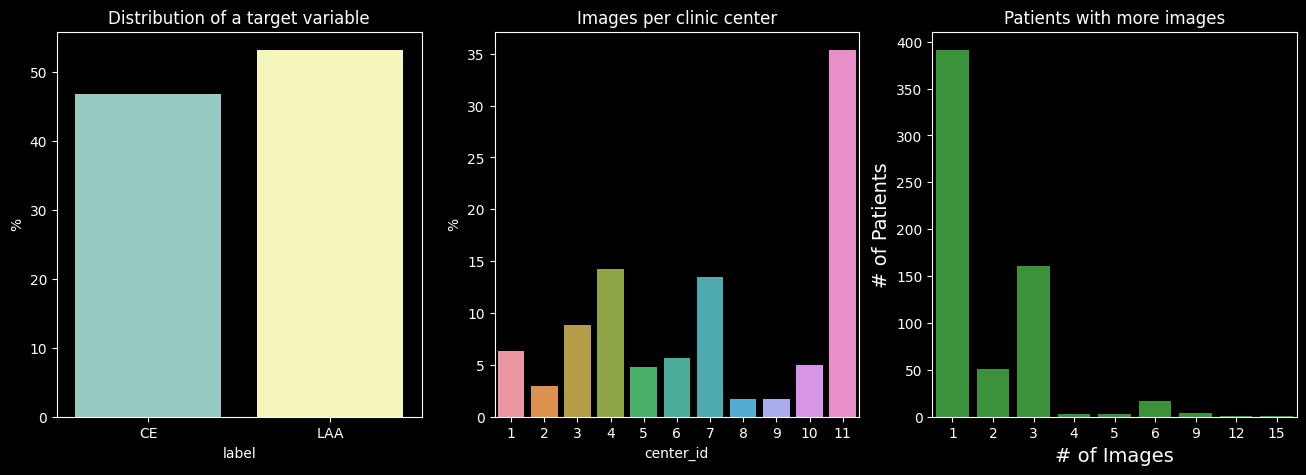

In [34]:
#After Class imbalance
plt.style.use('dark_background')
labels = dfCI.groupby('label')['label'].count().div(len(dfCI)).mul(100)
centers = dfCI.groupby("center_id")['center_id'].count().div(len(dfCI)).mul(100)
fig, ax = plt.subplots(1,3, figsize=(16,5))

sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")
sns.barplot(x=centers.index, y=centers.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")

sns.countplot(x=dfCI["patient_id"].value_counts().values,
             color="tab:green", ax=ax[2])
ax[2].set_title("Patients with more images")
ax[2].set_xlabel("# of Images", fontsize=14)
ax[2].set_ylabel("# of Patients", fontsize=14)
plt.show()

<AxesSubplot: ylabel='label'>

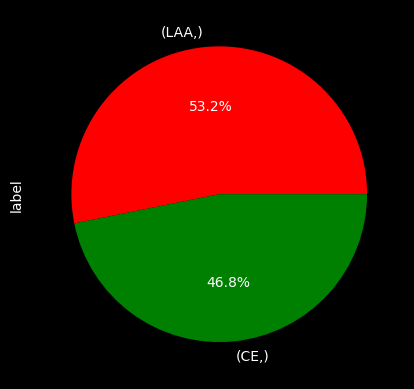

In [35]:
dfCI[["label"]].value_counts().plot.pie(autopct='%1.1f%%',ylabel="label", colors = ['red', 'green'])

Unique Values for: 




Text(0.5, 1.0, 'Unique value cou by  by feature')

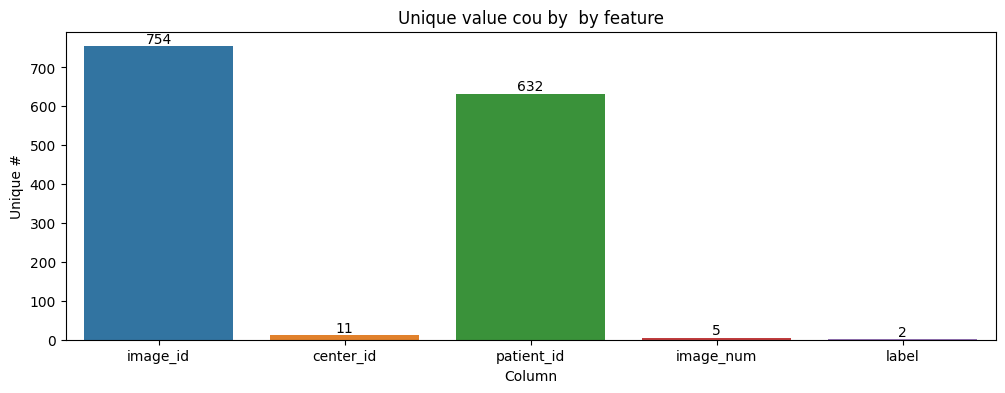

In [8]:
## No of unique values in each column
print('Unique Values for: ')
df_original.nunique()

print('\n')

nu = df_original.nunique().reset_index()
nu.columns = ['Column','Unique #']
plt.figure(figsize=(12,4))
ax = sns.barplot(x='Column', y='Unique #', data=nu)
ax.bar_label(ax.containers[0])
ax.set_title('Unique value cou by  by feature')

### Compute image sizes of each slide to analyze

<AxesSubplot: xlabel='center_id', ylabel='count'>

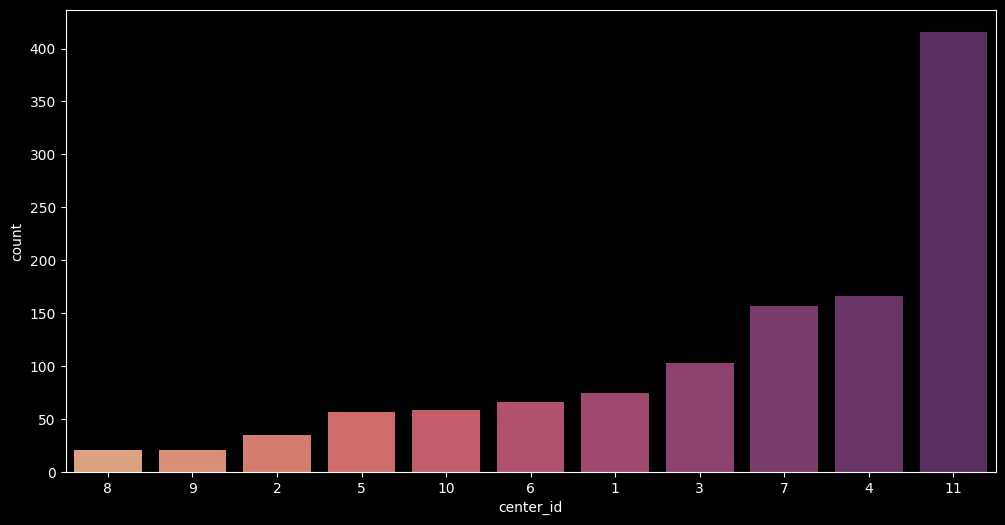

In [23]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_original, x='center_id', palette='flare', order=df_original['center_id'].value_counts(ascending=True).index)

In [5]:
# its bombing after certain size . Removing the size limit
PIL.Image.MAX_IMAGE_PIXELS = None
#Before
print(df_original.head())
# add images path to train and get width and height of images
df_original["path"] = "/home/bear/prakash/aai541/finalproject/data/train/" + df_original["image_id"] + ".tif"
df_original[["width", "height"]] = df_original["path"].apply(lambda x: pd.Series(PIL.Image.open(x).size))
#After
print(df_original.head())

   image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA
3  01adc5_0         11     01adc5          0   LAA
4  026c97_0          4     026c97          0    CE
   image_id  center_id patient_id  image_num label  \
0  006388_0         11     006388          0    CE   
1  008e5c_0         11     008e5c          0    CE   
2  00c058_0         11     00c058          0   LAA   
3  01adc5_0         11     01adc5          0   LAA   
4  026c97_0          4     026c97          0    CE   

                                                path  width  height  
0  /home/bear/prakash/aai541/finalproject/data/tr...  34007   60797  
1  /home/bear/prakash/aai541/finalproject/data/tr...   5946   29694  
2  /home/bear/prakash/aai541/finalproject/data/tr...  15255   61801  
3  /home/bear/prakash/aai541/finalproject/data/tr...  55831   26553  
4  /home/bear/praka

In [13]:
maxWClm = df_original['width'].idxmax()
print(maxClm)
maxHClm = df_original['height'].idxmax()
print(maxClm)
print(df_original['width'][maxWClm], df_original['height'][maxHClm])

660
660
99699 118076


(-0.5, 255.5, 255.5, -0.5)

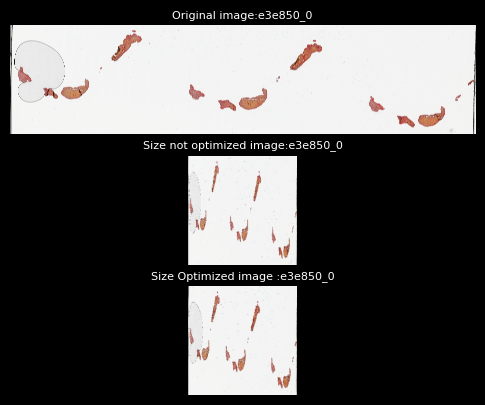

In [16]:
img_path = "./data/train/"+df_original.image_id[maxWClm]+".tif"
img_tmp = tifi.imread(img_path)
ax = plt.subplot(3, 1, 1)
plt.imshow(img_tmp)
plt.title(("Original image:"+df_original.image_id[maxWClm]), fontsize = 8 )
plt.axis("off")
img_path = "./data/train_jpg/"+df_original.image_id[maxWClm]+".jpg"
img_tmp = cv2.imread(img_path)
ax = plt.subplot(3, 1, 2)
plt.imshow(img_tmp)
plt.title(("Size not optimized image:"+df_original.image_id[maxWClm]), fontsize = 8 )
plt.axis("off")
img_path = "./data/train_jpg2/"+df_original.image_id[maxWClm]+".jpg"
img_tmp = cv2.imread(img_path)
ax = plt.subplot(3, 1, 3)
plt.imshow(img_tmp)
plt.title(("Size Optimized image :"+df_original.image_id[maxWClm]), fontsize = 8 )
plt.axis("off")


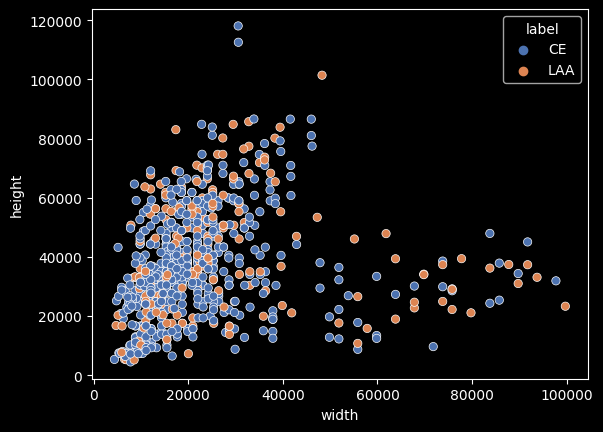

In [9]:
#plotting scatter plaot of each image height and width to see the image size spread
sns.scatterplot(x="width", y="height", data=df_original, hue="label", palette="deep")
plt.show()

In [7]:
df_original.label.value_counts()/df_original.shape[0], df_original.center_id.nunique(), df_original.center_id.unique()


(CE     0.725464
 LAA    0.274536
 Name: label, dtype: float64,
 11,
 array([11,  4,  5,  7,  1,  6, 10,  3,  2,  8,  9]))

### CE has 72.5% images and LAA has 27.5%
### 11 center has more images data
### There is only one image per patient for most of the cases. There are more than one image per patient for 89 patients and 66 patients has just one image

In [10]:
# Since 3rd plot shows a patient can have more than one image. Make sure labels are marked same
ImageCount = df_original["patient_id"].value_counts() 
# Get count for more than one image
ImageCount = ImageCount[ImageCount > 1] 
# get thier labels
SlideLabel = df_original.loc[df_original["patient_id"].isin(ImageCount.index)].groupby("patient_id")["label"].apply(list)
print("Count List:", ImageCount)
# Go through each label and make sure they are same. If not print Different
for i, sample in SlideLabel.items():
    if len(set(sample)) > 1:
        print(i, "DIFFERENT LABELS", sample)
    break

Count List: 91b9d3    5
3d10be    5
09644e    5
56d177    5
4f6fb1    4
         ..
0ee750    2
19b036    2
1db82d    2
0ed87f    2
1f9d4f    2
Name: patient_id, Length: 89, dtype: int64


In [11]:
print(df_other.head())

   image_id patient_id  image_num  other_specified    label
0  01f2b3_0     01f2b3          0              NaN  Unknown
1  01f2b3_1     01f2b3          1              NaN  Unknown
2  02ebd5_0     02ebd5          0              NaN  Unknown
3  0412ab_0     0412ab          0              NaN  Unknown
4  04414e_0     04414e          0  Hypercoagulable    Other


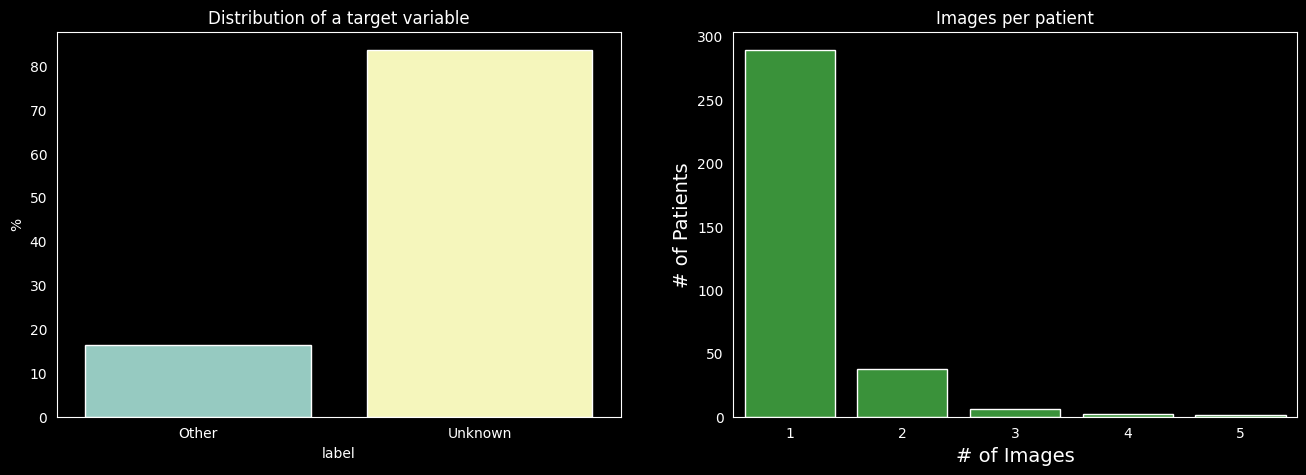

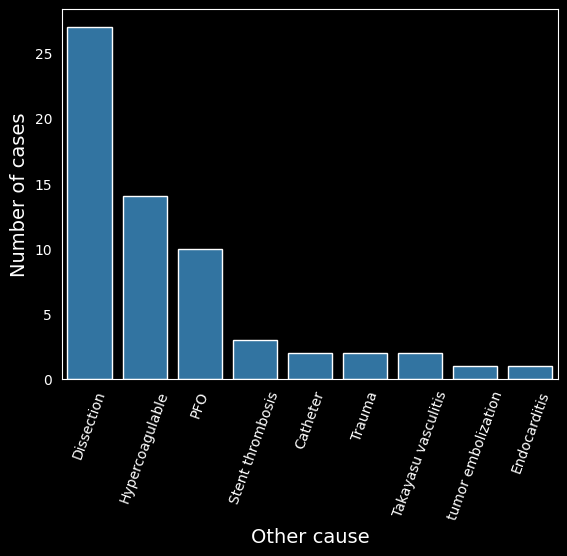

In [14]:
# Checking the other
# check label distribution
plt.style.use('dark_background')
labels = df_other.groupby('label')['label'].count().div(len(df_other)).mul(100)
other_specified = df_other["other_specified"].value_counts()
fig, ax = plt.subplots(1,2, figsize=(16,5))

sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")

#sns.barplot(x=other_specified.index, y=other_specified.values, order=other_specified.index, 
#            color="tab:blue", ax=ax[1])
#ax[1].set_title("Images per patient")
#ax[1].set_xlabel("Other Cause", fontsize=14)
#ax[1].set_ylabel("# of cases", fontsize=14)
#ax[1].set_xticklabels(ax[1].get_xticks(), rotation = 45)

sns.countplot(x=df_other["patient_id"].value_counts().values,
             color="tab:green", ax=ax[1])
ax[1].set_title("Images per patient")
ax[1].set_xlabel("# of Images", fontsize=14)
ax[1].set_ylabel("# of Patients", fontsize=14)
plt.show()

sns.barplot(x=other_specified.index, y=other_specified.values, order=other_specified.index, 
            color="tab:blue")
plt.xticks(rotation=70)
plt.xlabel("Other cause", fontsize=14)
plt.ylabel("Number of cases", fontsize=14)
plt.show()


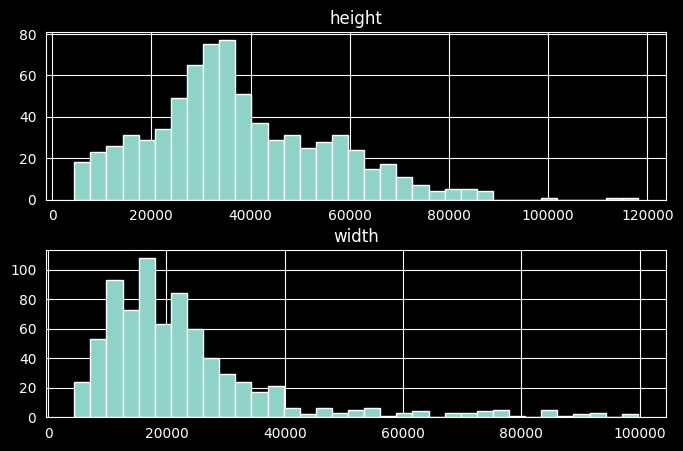

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))
for i, col in enumerate(["height", "width"]):
    _= df_original[[col]].hist(ax=axes[i], bins=35)

Text(0.5, 1.0, 'Distribution of Labels by Center')

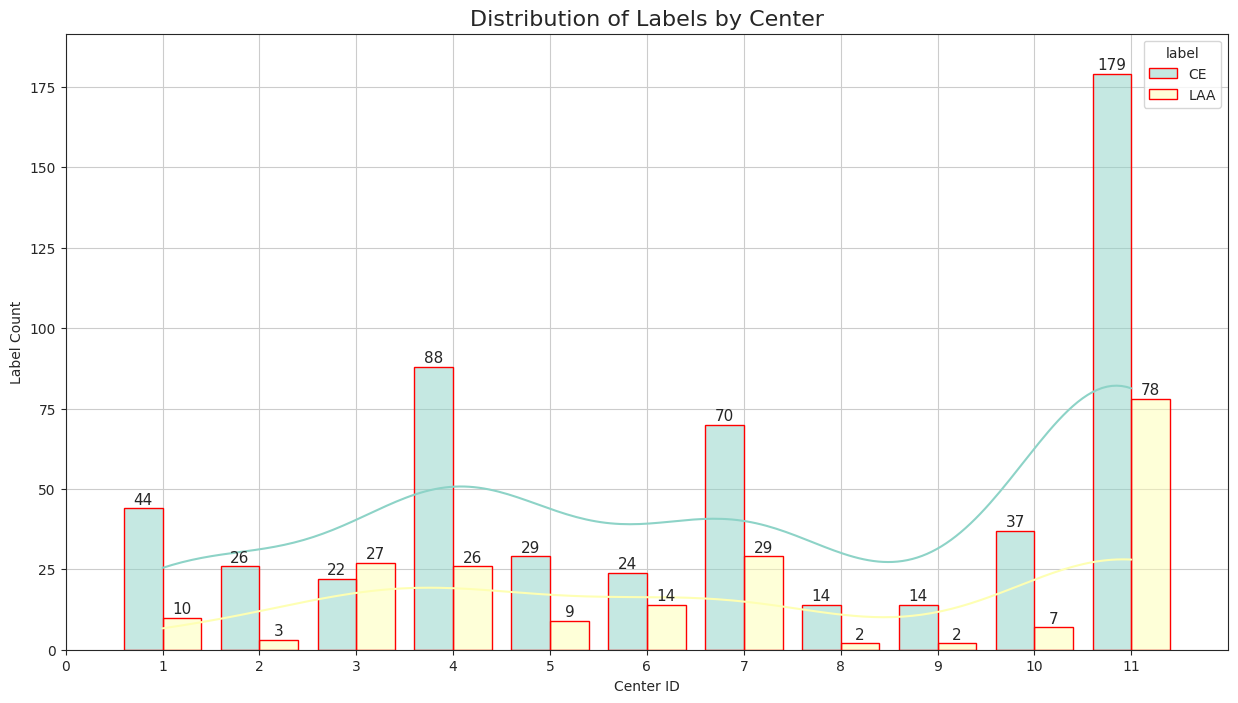

In [26]:
sns.set_style("ticks")
plt.figure(figsize=(15,8))
g = sns.histplot(data=df_original, x="center_id", hue="label", 
                 multiple="dodge", color='orange', edgecolor='red',discrete=True,
                 kde=True, shrink=0.8)
g.set(xlabel='Center ID', ylabel='Label Count')
g.set(xlim=(0, 12), xticks=np.arange(0,12,1))
for p in g.patches:
    x, w, h = p.get_x(), p.get_width(), p.get_height()
    if h > 0:
        g.text(x + w / 2, h, f'{h}\n', ha='center', va='center', size=11)
g.margins(y=0.07)
g.grid(True)
g.set_title('Distribution of Labels by Center', fontsize=16)

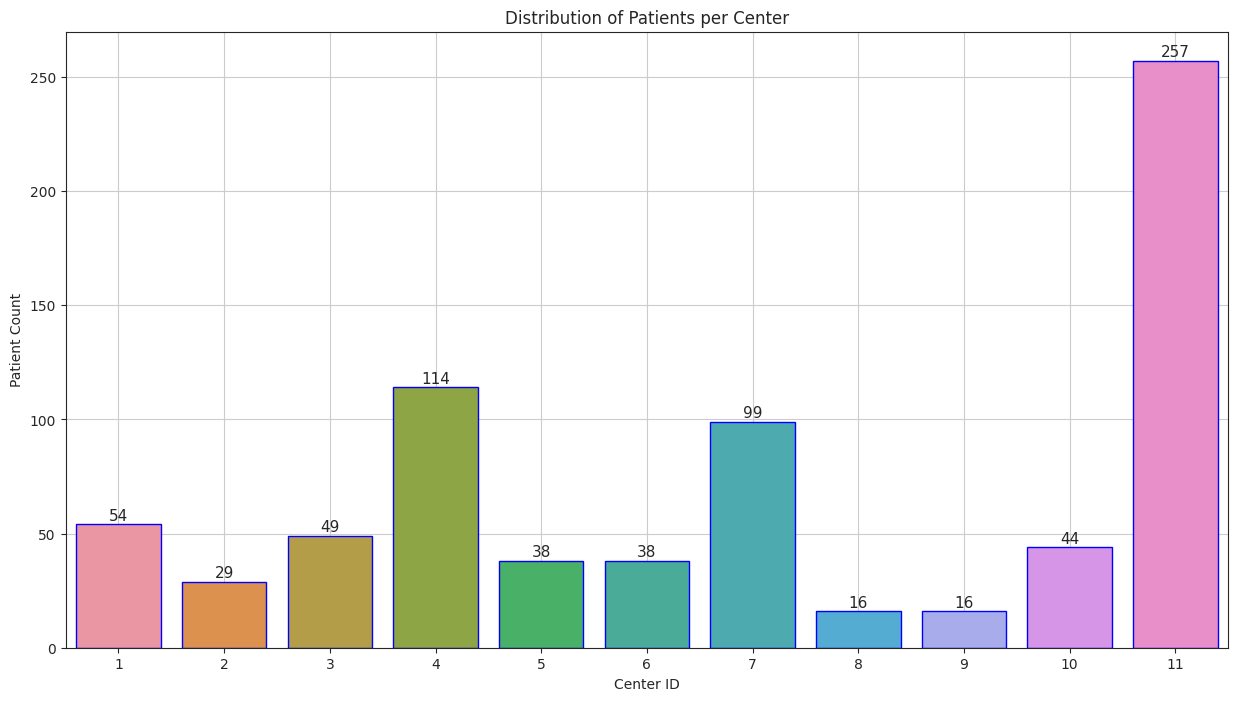

In [30]:
centers = df_original.groupby("center_id")['center_id'].count()
sns.set_style("ticks")
plt.figure(figsize=(15,8))

g = sns.barplot(x=centers.index, y=centers.values, orient='v', edgecolor='blue')
for p in g.patches:
    x, w, h = p.get_x(), p.get_width(), p.get_height()
    if h > 0:
        g.text(x + w / 2, h, f'{h:.0f}\n', ha='center', va='center', size=11)
g.set_title('Distribution of Patients per Center', fontsize=12)
g.set(ylabel="Patient Count", xlabel='Center ID')
g.grid(True)

In [ ]:
std_dev_obj = []
fig, axes = plt.subplots(2,3, figsize=(18,6))
for i, ax in enumerate(axes.flat):
    img_matrix = imgs_object[i].ravel()
    std_dev = np.std(img_matrix)
    std_dev_obj.append(std_dev)
    sns.histplot(img_matrix, bins=np.arange(0,1, 0.01), ax=ax)
    ax.text(0.05,0.85, f'std dev: {std_dev:.2f}', size=15, transform = ax.transAxes)
    ax.set_title(f'img {i}') 
plt.suptitle('Histograms for images w. object')
plt.tight_layout()
plt.show()

CPU times: user 1min 32s, sys: 14.3 s, total: 1min 47s
Wall time: 1min 9s


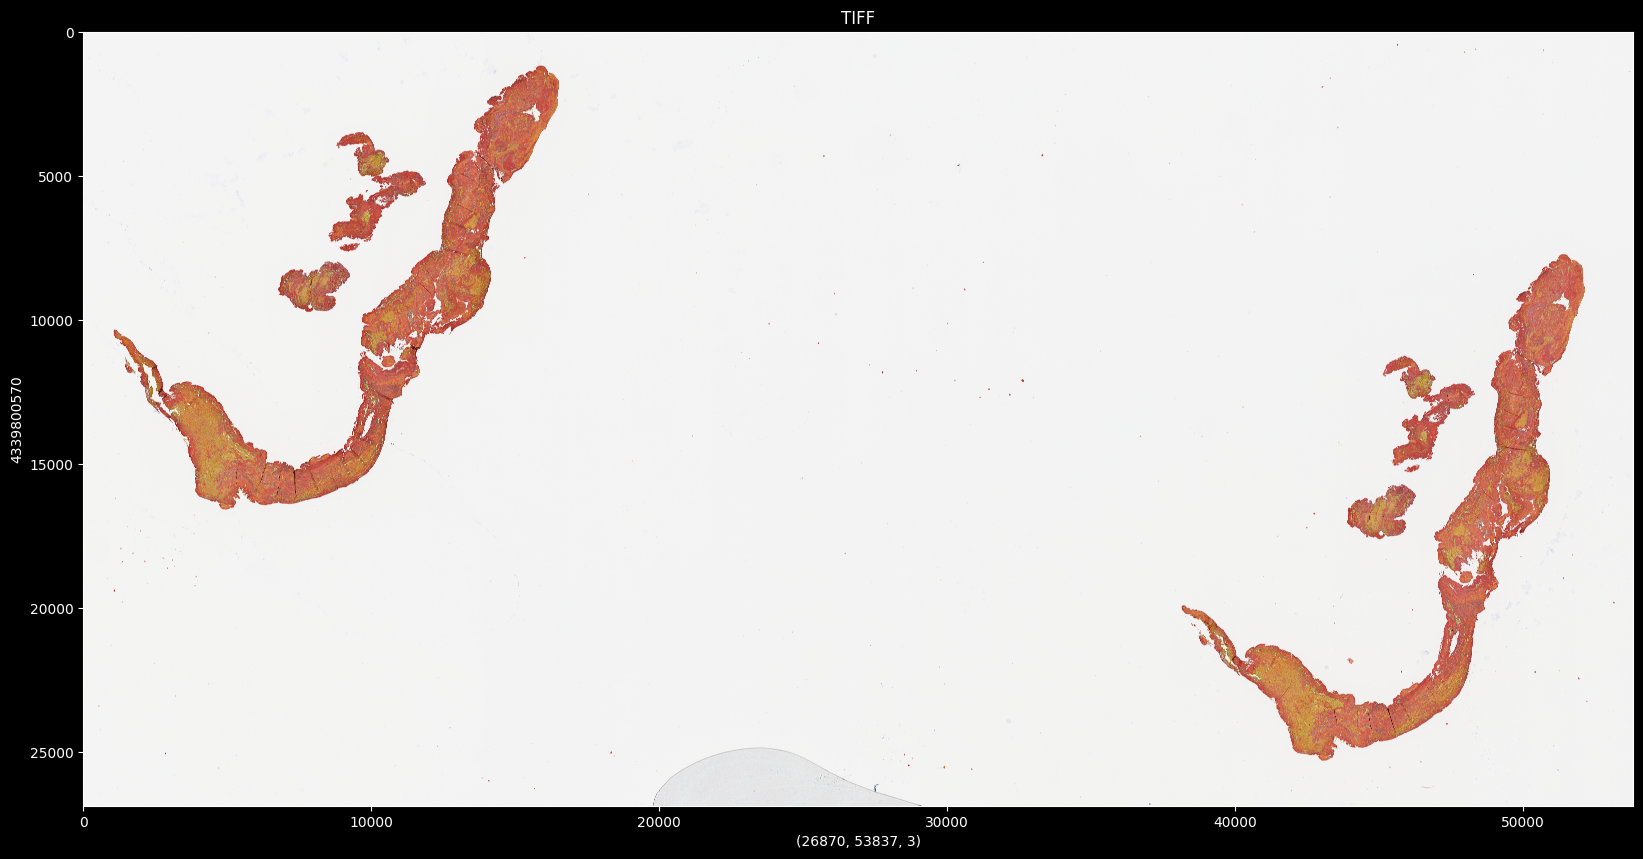

In [14]:

%%time
figure = plt.figure(figsize=(20,20))
Reading_Image = tifi.imread("/home/bear/prakash/aai541/finalproject/data/train/0d533f_0.tif")
plt.xlabel(Reading_Image.shape)
plt.ylabel(Reading_Image.size)
plt.title("TIFF")
plt.imshow(Reading_Image)

In [15]:
import cv2

img = cv2.resize(tifi.imread("/home/bear/prakash/aai541/finalproject/data/train/0d533f_0.tif"), (512, 256))
cv2.imwrite('/home/bear/prakash/aai541/finalproject/data/0d533f_0.jpg', img)
gc.collect()


68

In [16]:
%pwd

'/home/bear/prakash/aai541/finalproject'

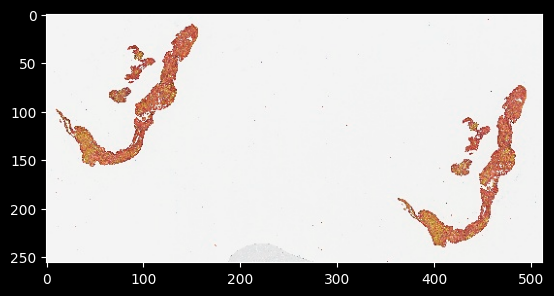

In [16]:
import cv2
img = cv2.imread('./data/0d533f_0.jpg')
plt.imshow(img)

## Image resizing task
### Resize one LAA image
### Resige in CE image
### Plot both

(256, 256)


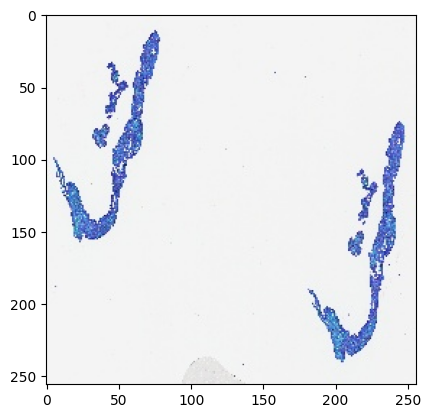

In [16]:
from PIL import Image
img_rgb = Image.open('./data/0d533f_0.jpg')
print(img_rgb.size)
img_tmp = np.reshape(img_gray, [1, 128, 128, 4])


In [ ]:
#convert test to pdf
# For each Tiff file, save it as jpg file with 256 x 256 dimenision
for x in range(int(df_test.shape[0])):
    img_path = "./data/test/"+df_test.image_id[x]+".tif"
    img_path2 = "./data/test_jpg2/"+df_test.image_id[x]+".jpg"
    if(os.path.isfile(img_path2)):
        print(img_path2, " exists")
    else:
        img_tmp = tifi.imread(img_path)
        img_tmp = getridofEmptySpaces(img_tmp)
        img_tmp = cv2.resize(img_tmp, (256, 256))
        cv2.imwrite(img_path2, img_tmp)
        print("Created ",img_path2)
        del img_tmp  # to free memory
        gc.collect() # to free memory
        # print(gc.collect())
print("Completed Tiff to PDF Conversion")

In [3]:
def getridofEmptySpaces(img):
    
    print('Original image shape : ', img.shape)
    print('Removing rows ..................')

    
#     Code to identify empty rows.
    idx = []
    for i in trange(img.shape[0]):
        if len(np.unique(img[i,:])) <= 100:
            idx.append(i)
            
    print('Rows removed : ', len(idx))
    
    img = np.delete(img, idx, axis=0)
    
    print('New image shape : ', img.shape)
    
    print('Removing columns ..................')
    idxy = []
    for i in trange(img.shape[1]):
        
        if len(np.unique(img[:,i])) <= 100:
            idxy.append(i)
            
    print('Columns removed : ', len(idxy))
            
    img = np.delete(img, idxy, axis=1)
    print('New image shape : ', img.shape)
    
            
    del idx, idxy
    gc.collect()
    
    return img

Original image shape :  (26870, 53837, 3)
Removing rows ..................


100%|████████████████████████████████████| 26870/26870 [01:24<00:00, 319.09it/s]


Rows removed :  1041
New image shape :  (25829, 53837, 3)
Removing columns ..................


100%|████████████████████████████████████| 53837/53837 [01:41<00:00, 529.79it/s]


Columns removed :  21348
New image shape :  (25829, 32489, 3)


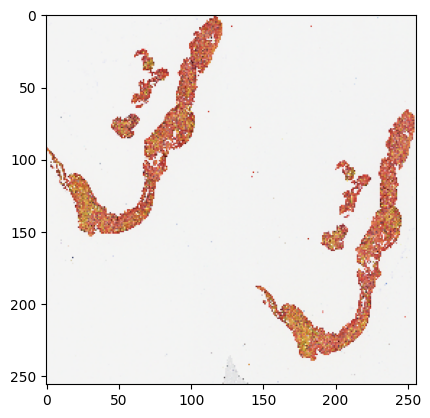

In [11]:
Reading_Image = tifi.imread("/home/bear/prakash/aai541/finalproject/data/train/0d533f_0.tif")
Reading_Image = getridofEmptySpaces(Reading_Image)
img_tmp = cv2.resize(Reading_Image, (256, 256))
plt.imshow(img_tmp)

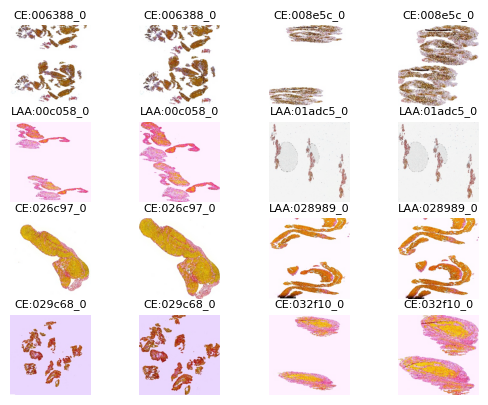

In [6]:
j=0
for i in range(16):
    if (i%2):
        img_path = "./data/train_jpg2/"+df_original.image_id[j]+".jpg"
        img_tmp = cv2.imread(img_path)
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(img_tmp)
        plt.title((df_original.label[j]+":"+df_original.image_id[j]), fontsize = 8 )
        plt.axis("off")
        j=j+1
    else:
        img_path = "./data/train_jpg/"+df_original.image_id[j]+".jpg"
        img_tmp = cv2.imread(img_path)
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(img_tmp)
        plt.title((df_original.label[j]+":"+df_original.image_id[j]), fontsize = 8 )
        plt.axis("off")

In [34]:
def case_study(df, index):
    plt.style.use('default')
    
    img_id = df.image_id[index]
    path = "./data/train/"+df.image_id[index]+".tif"
    patient_id = df.patient_id[index]
    center_id = df.center_id[index]
    label = df.label[index]
    pdfpath = "./data/train_jpg2/"+df.image_id[index]+".jpg"


    
    print('\033[1m' + 'Case study : {}'.format(img_id) + '\033[0m')
    print('\n------------------------------\n')
    print('\033[1m' + 'General info: \n' + '\033[0m')
    print('\033[1m' + 'Patient ID: ' '\033[0m' + f'{patient_id}')  
    print('\033[1m' + 'Center ID: ' '\033[0m' + f'{center_id}')  
    print('\033[1m' + 'Etiology type: ' '\033[0m' + f'{label}')
    print('\n------------------------------\n')
    # https://www.kaggle.com/code/datark1/eda-images-processing-and-exploration/notebook 
    
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(img, (0,0), fx=0.05, fy=0.05)  
    img_OPT = cv2.imread(pdfpath)

    print('\033[1m' + 'Image info: \n' + '\033[0m')
    print('\033[1m' + 'Original shape: \n' + '\033[0m' + f'{img.shape}')
    print('\033[1m' + 'Resized shape: \n' + '\033[0m' + f'{image_resized.shape}')
    print('\033[1m' + 'OPTMIZED shape: \n' + '\033[0m' + f'{img_OPT.shape}')
    fig, ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(img)
    ax[0].set_title('Original image')
    
    ax[1].imshow(image_resized)
    ax[1].set_title('Resized image')
  
    ax[2].imshow(img_OPT)
    ax[2].set_title('OPTIMIZED image')
    
    
    # plt.suptitle('Patient ID: ' + f'{patient_id}', y=0.7)
    plt.tight_layout()
    plt.show()
    return img, image_resized

Case study : 03d1ec_0

------------------------------

General info: 

Patient ID: 03d1ec
Center ID: 11
Etiology type: LAA

------------------------------

Image info: 

Original shape: 
(30421, 23125, 3)
Resized shape: 
(1521, 1156, 3)
OPTMIZED shape: 
(256, 256, 3)


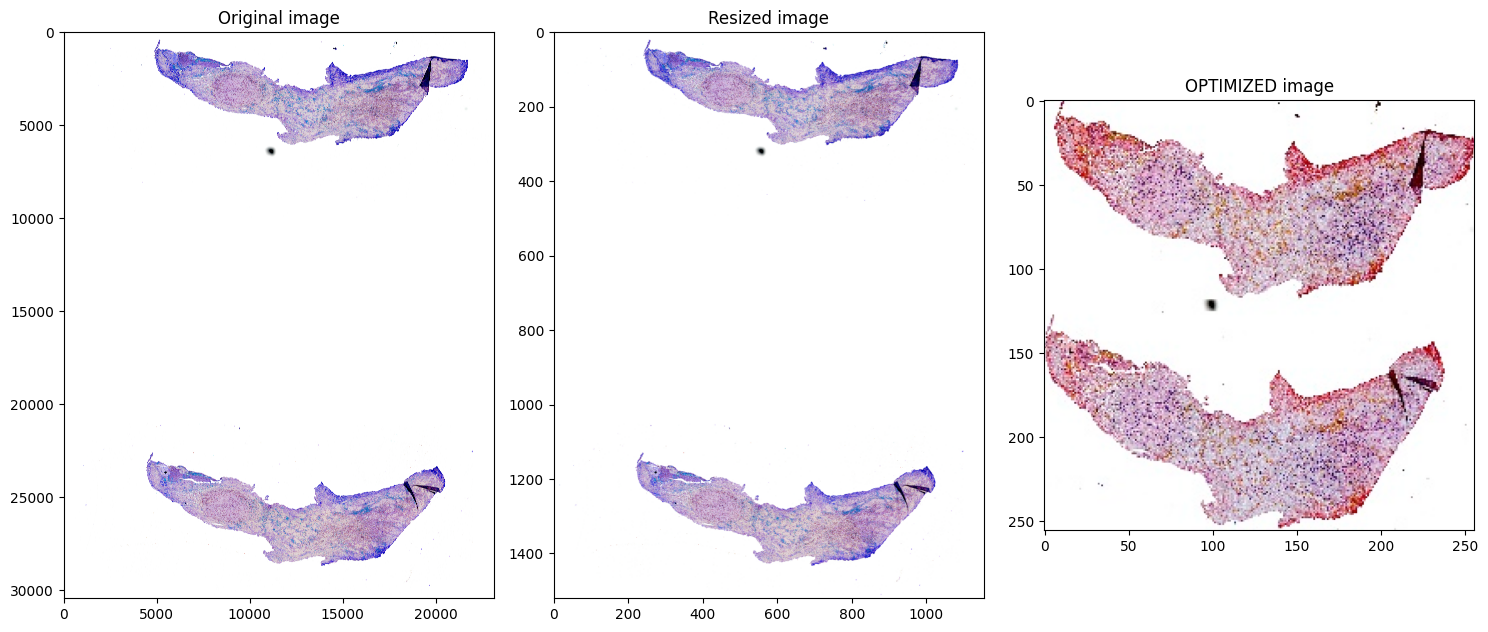

In [35]:
img_CE, img_resized_CE = case_study(df_original, 10)